# 📦 Optimización de Inventario: Modelo Newsvendor

## Objetivo

Diseñar una función de optimización que determine la cantidad óptima de pedido, minimizando el costo total esperado al balancear:

1. **Costo de Stockout (Cu)**: Margen perdido por unidad no vendida
2. **Costo de Overstock (Co)**: Costo de mantener inventario excedente

## Modelo Matemático

El modelo Newsvendor clásico nos da la cantidad óptima $Q^*$ como:

$$Q^* = F^{-1}(p)$$

donde $p$ es el **critical fractile**:

$$p = \frac{C_u}{C_u + C_o}$$

Si asumimos demanda $D \sim N(\mu, \sigma^2)$, entonces:

$$Q^* = \mu + z(p) \cdot \sigma$$

donde $z(p) = \Phi^{-1}(p)$ es el cuantil de la distribución Normal estándar.

### Interpretación de p (Agresividad)

- **p ≈ 0.9-0.99**: Ser agresivo, pedir más (Cu >> Co)
- **p ≈ 0.5**: Balanceado (Cu ≈ Co)
- **p ≈ 0.1-0.3**: Ser conservador, pedir menos (Co >> Cu)

---

## 1. Setup y Configuración

In [18]:
import sys
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

# Importar módulos propios
from data_source import DataSource
from forecast import DemandForecaster
from optimizer import InventoryOptimizer, ReplenishmentPlanner

## 2. Carga de Datos

In [ ]:
# Rutas a los datos
base_path = '../data/01_supply_optimization'

repo = DataSource(
    ventas_path=f'{base_path}/ventas_historicas.csv',
    inventario_path=f'{base_path}/inventario_actual.csv',
    catalogo_path=f'{base_path}/catalogo_productos.csv',
    tiendas_path=f'{base_path}/maestro_tiendas.csv',
).load()

# Explorar datos
print("\nDimensiones:")
print(f"  - Ventas: {len(repo.ventas):,} registros")
print(f"  - Inventario: {len(repo.inventario):,} SKU-tiendas")
print(f"  - Catálogo: {len(repo.catalogo)} productos")
print(f"  - Tiendas: {len(repo.tiendas)} tiendas")


Dimensiones:
  - Ventas: 14,560 registros
  - Inventario: 160 SKU-tiendas
  - Catálogo: 8 productos
  - Tiendas: 20 tiendas


In [20]:
catalogo = repo.catalogo.copy()
catalogo['margen_unitario'] = catalogo['precio_venta'] - catalogo['costo_unitario']
catalogo['margen_porcentaje'] = (catalogo['margen_unitario'] / catalogo['precio_venta'] * 100).round(1)
catalogo['p_critico'] = catalogo['margen_unitario'] / (
    catalogo['margen_unitario'] + catalogo['costo_almacenamiento_semanal']
)

print("\nCatálogo de Productos con Análisis de Costos:")
print(catalogo[['nombre', 'costo_unitario', 'precio_venta', 'margen_unitario', 
                'margen_porcentaje', 'costo_almacenamiento_semanal', 'p_critico']].to_string(index=False))


Catálogo de Productos con Análisis de Costos:
         nombre  costo_unitario  precio_venta  margen_unitario  margen_porcentaje  costo_almacenamiento_semanal  p_critico
          Tinto             800          2500             1700               68.0                            10   0.994152
 Café con Leche            1200          3500             2300               65.7                            15   0.993521
     Cappuccino            1500          4500             3000               66.7                            15   0.995025
    Pan de Bono            1000          2800             1800               64.3                            20   0.989011
        Buñuelo             800          2500             1700               68.0                            20   0.988372
      Croissant            1200          3500             2300               65.7                            25   0.989247
Pastel de Pollo            1500          3500             2000               57.1           

## 3. Análisis de la Estructura de Costos

El **Critical Fractile (p)** determina qué tan agresiva debe ser nuestra política de pedidos:

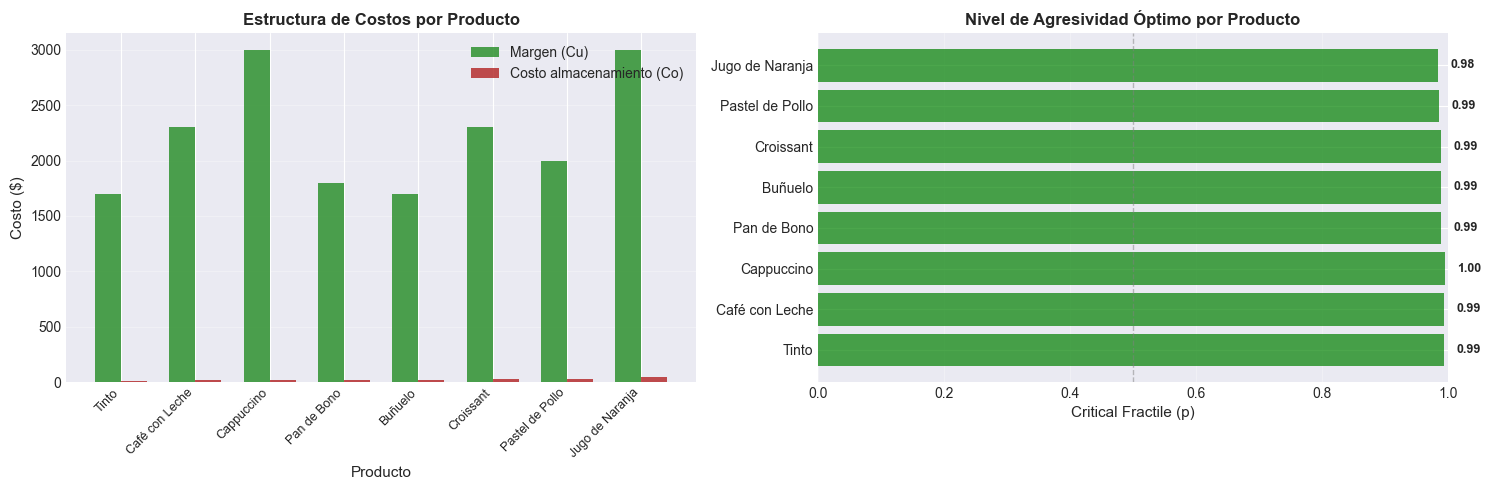


Interpretación:
  - p > 0.8 (verde): Ser AGRESIVO, el margen es alto vs. costo de almacenamiento
  - 0.5 < p < 0.8 (naranja): BALANCEADO
  - p < 0.5 (rojo): Ser CONSERVADOR, el costo de almacenamiento es significativo


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Margen vs Costo de almacenamiento
ax1 = axes[0]
x = np.arange(len(catalogo))
width = 0.35

ax1.bar(x - width/2, catalogo['margen_unitario'], width, label='Margen (Cu)', color='forestgreen', alpha=0.8)
ax1.bar(x + width/2, catalogo['costo_almacenamiento_semanal'], width, label='Costo almacenamiento (Co)', color='firebrick', alpha=0.8)

ax1.set_xlabel('Producto', fontsize=11)
ax1.set_ylabel('Costo ($)', fontsize=11)
ax1.set_title('Estructura de Costos por Producto', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(catalogo['nombre'], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Critical Fractile (p) - Nivel de Agresividad
ax2 = axes[1]
colors = ['green' if p > 0.8 else 'orange' if p > 0.5 else 'red' for p in catalogo['p_critico']]
bars = ax2.barh(catalogo['nombre'], catalogo['p_critico'], color=colors, alpha=0.7)

ax2.axvline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='p=0.5 (neutral)')
ax2.set_xlabel('Critical Fractile (p)', fontsize=11)
ax2.set_title('Nivel de Agresividad Óptimo por Producto', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)

# Añadir etiquetas de valores
for i, (bar, val) in enumerate(zip(bars, catalogo['p_critico'])):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("  - p > 0.8 (verde): Ser AGRESIVO, el margen es alto vs. costo de almacenamiento")
print("  - 0.5 < p < 0.8 (naranja): BALANCEADO")
print("  - p < 0.5 (rojo): Ser CONSERVADOR, el costo de almacenamiento es significativo")

## 4. Optimización de Inventario

Ejecutamos el pipeline completo que integra:
1. Pronósticos de demanda con incertidumbre (μ, σ)
2. Cálculo de la cantidad óptima usando el modelo Newsvendor
3. Generación de recomendaciones de pedido

In [ ]:
# Configurar componentes
forecaster = DemandForecaster(
    min_history_days=30,
    interval_width=0.95,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05
)

optimizer = InventoryOptimizer(
    z_clip=(-3, 3),
    sigma_min=0.1
)

# Ejecutar pipeline completo
planner = ReplenishmentPlanner(repo, forecaster, optimizer)
plan = planner.run(verbose=True)

print(f"\n✅ Plan de pedidos generado para {len(plan)} SKU-tiendas")

12:44:50 - cmdstanpy - INFO - Chain [1] start processing


📊 Cargando datos históricos de ventas...
🔮 Generando pronósticos de demanda con incertidumbre...


12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing
12:44:50 - cmdstanpy - INFO - Chain [1] 

📦 Cargando inventario y costos actuales...
⚙️  Optimizando política de pedidos para 160 SKU-tiendas...
✅ Optimización completada!
   Total a pedir: 12307 unidades
   Costo total esperado: $2,204,360

✅ Plan de pedidos generado para 160 SKU-tiendas


In [23]:
# Visualizar primeras recomendaciones
print("\n📦 Primeras 15 recomendaciones:")
display_cols = [
    'id_tienda', 'nombre', 'stock_actual', 'Q_objetivo_semana', 'pedido_sugerido',
    'mu_semana', 'sigma_semana', 'p_critico_agresividad', 'costo_total_esperado'
]
print(plan[display_cols].head(15).to_string(index=False))


📦 Primeras 15 recomendaciones:
id_tienda          nombre  stock_actual  Q_objetivo_semana  pedido_sugerido  mu_semana  sigma_semana  p_critico_agresividad  costo_total_esperado
 STORE_01           Tinto             1          50.577222        49.577222  47.306966      7.107143               0.677291           6401.817043
 STORE_01  Café con Leche            10          69.971323        59.971323  65.756343     10.615463               0.654339          13757.500911
 STORE_01      Cappuccino            33          66.799292        33.799292  63.074943      8.770525               0.664452          14435.669043
 STORE_01     Pan de Bono            11          53.994651        42.994651  51.389481      7.361049               0.638298           7778.579533
 STORE_01         Buñuelo             3          70.446677        67.446677  66.008114      9.805514               0.674603           8897.895396
 STORE_01       Croissant            13          89.369459        76.369459  85.562107      

In [24]:
# Resumen ejecutivo
print("\n" + "="*80)
print("📊 RESUMEN EJECUTIVO")
print("="*80)
print(f"Total SKU-tiendas: {len(plan)}")
print(f"Total unidades en inventario actual: {plan['stock_actual'].sum():.0f}")
print(f"Total unidades objetivo (Q*): {plan['Q_objetivo_semana'].sum():.0f}")
print(f"Total unidades a pedir: {plan['pedido_sugerido'].sum():.0f}")
print(f"\nCosto esperado total: ${plan['costo_total_esperado'].sum():,.2f}")
print(f"  - Costo stockout: ${plan['costo_esperado_stockout'].sum():,.2f}")
print(f"  - Costo overstock: ${plan['costo_esperado_overstock'].sum():,.2f}")
print(f"\nNivel de servicio promedio: {plan['service_level_approx'].mean():.1%}")
print(f"Agresividad promedio (p): {plan['p_critico_agresividad'].mean():.3f}")
print("="*80)


📊 RESUMEN EJECUTIVO
Total SKU-tiendas: 160
Total unidades en inventario actual: 3367
Total unidades objetivo (Q*): 15608
Total unidades a pedir: 12307

Costo esperado total: $2,204,360.29
  - Costo stockout: $935,471.26
  - Costo overstock: $1,268,889.03

Nivel de servicio promedio: 64.0%
Agresividad promedio (p): 0.640


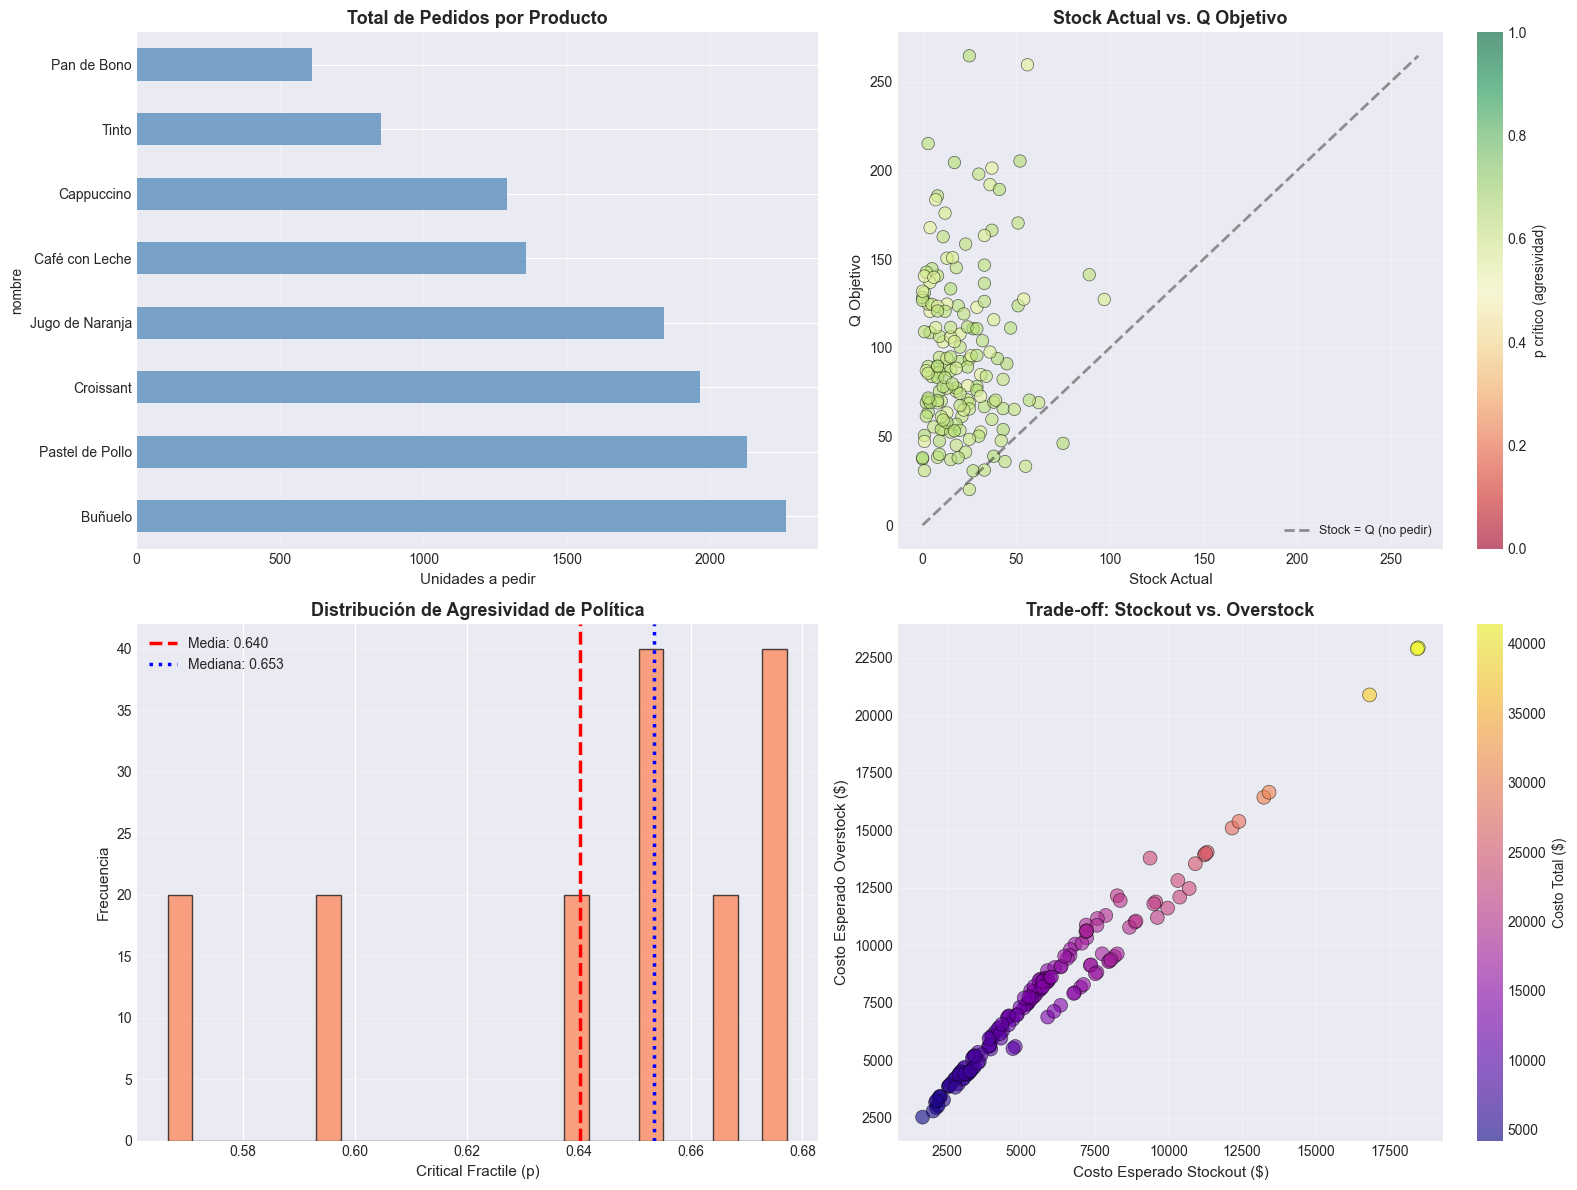

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Pedidos por producto
ax1 = axes[0, 0]
pedidos_por_producto = plan.groupby('nombre')['pedido_sugerido'].sum().sort_values(ascending=False)
pedidos_por_producto.plot(kind='barh', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title('Total de Pedidos por Producto', fontsize=13, fontweight='bold')
ax1.set_xlabel('Unidades a pedir', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# 2. Stock actual vs. Q objetivo
ax2 = axes[0, 1]
scatter = ax2.scatter(plan['stock_actual'], plan['Q_objetivo_semana'], 
                     alpha=0.6, s=80, c=plan['p_critico_agresividad'], 
                     cmap='RdYlGn', vmin=0, vmax=1, edgecolors='black', linewidth=0.5)
max_val = max(plan['stock_actual'].max(), plan['Q_objetivo_semana'].max())
ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.4, linewidth=2, label='Stock = Q (no pedir)')
ax2.set_xlabel('Stock Actual', fontsize=11)
ax2.set_ylabel('Q Objetivo', fontsize=11)
ax2.set_title('Stock Actual vs. Q Objetivo', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('p crítico (agresividad)', fontsize=10)

# 3. Distribución de agresividad
ax3 = axes[1, 0]
plan['p_critico_agresividad'].hist(bins=25, ax=ax3, color='coral', edgecolor='black', alpha=0.7)
ax3.axvline(plan['p_critico_agresividad'].mean(), color='red', linestyle='--', linewidth=2.5,
            label=f"Media: {plan['p_critico_agresividad'].mean():.3f}")
ax3.axvline(plan['p_critico_agresividad'].median(), color='blue', linestyle=':', linewidth=2.5,
            label=f"Mediana: {plan['p_critico_agresividad'].median():.3f}")
ax3.set_xlabel('Critical Fractile (p)', fontsize=11)
ax3.set_ylabel('Frecuencia', fontsize=11)
ax3.set_title('Distribución de Agresividad de Política', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. Trade-off de costos
ax4 = axes[1, 1]
scatter2 = ax4.scatter(plan['costo_esperado_stockout'], plan['costo_esperado_overstock'], 
            alpha=0.6, s=100, c=plan['costo_total_esperado'], cmap='plasma', 
            edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Costo Esperado Stockout ($)', fontsize=11)
ax4.set_ylabel('Costo Esperado Overstock ($)', fontsize=11)
ax4.set_title('Trade-off: Stockout vs. Overstock', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax4)
cbar2.set_label('Costo Total ($)', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Análisis de Sensibilidad

Exploramos cómo cambia Q* ante diferentes niveles de incertidumbre (σ) y costos (Co).

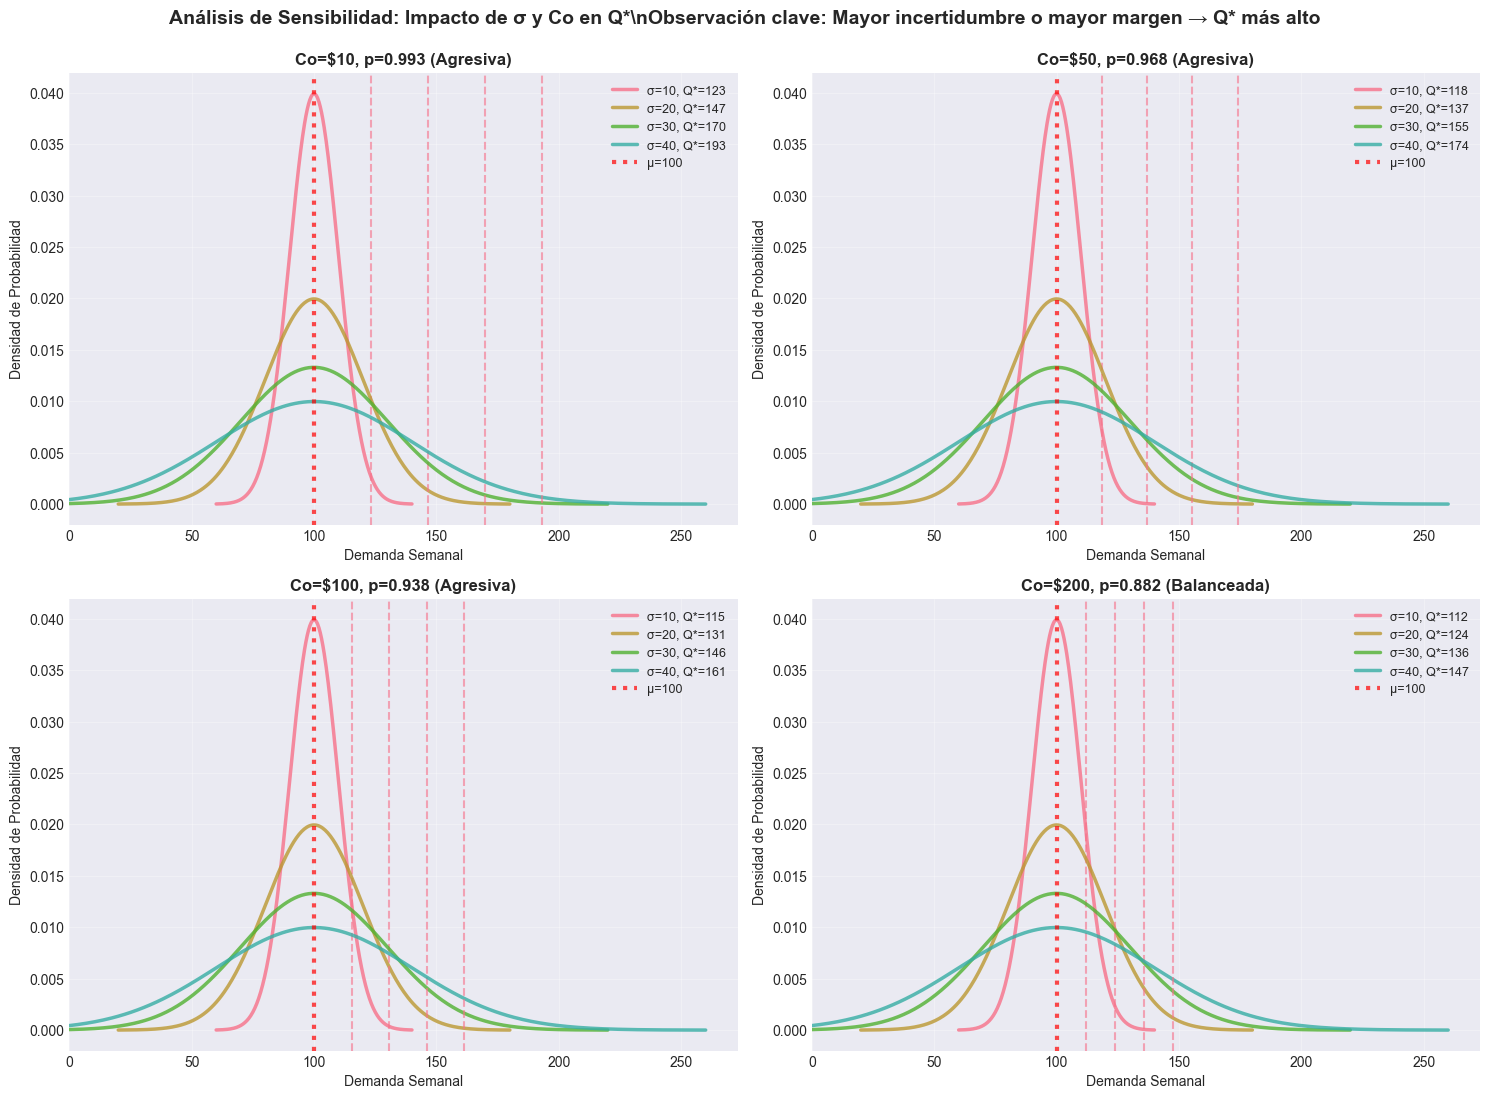


💡 Observaciones:
  1. A mayor incertidumbre (σ), mayor buffer de seguridad → Q* aumenta
  2. A mayor costo de overstock (Co), política más conservadora → Q* disminuye
  3. El critical fractile (p = Cu/(Cu+Co)) determina la agresividad


In [26]:
# Parámetros base para análisis
mu = 100
sigma_values = [10, 20, 30, 40]
Cu = 1500
Co_values = [10, 50, 100, 200]

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
axes = axes.flatten()

for idx, Co in enumerate(Co_values):
    ax = axes[idx]
    
    for sigma in sigma_values:
        result = optimizer.compute_order_quantity(
            mu_week=mu,
            sigma_week=sigma,
            stock_actual=0,
            margen_unitario=Cu,
            costo_overstock_unitario=Co
        )
        
        # Graficar distribución de demanda y Q*
        x = np.linspace(max(0, mu - 4*sigma), mu + 4*sigma, 300)
        y = norm.pdf(x, mu, sigma)
        
        ax.plot(x, y, label=f'σ={sigma}, Q*={result.Q_objetivo:.0f}', linewidth=2.5, alpha=0.8)
        ax.axvline(result.Q_objetivo, linestyle='--', alpha=0.6, linewidth=1.5)
    
    ax.axvline(mu, color='red', linestyle=':', linewidth=3, label=f'μ={mu}', alpha=0.7)
    
    p = Cu / (Cu + Co)
    estrategia = "Agresiva" if p > 0.9 else "Conservadora" if p < 0.7 else "Balanceada"
    ax.set_title(f'Co=${Co}, p={p:.3f} ({estrategia})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Demanda Semanal', fontsize=10)
    ax.set_ylabel('Densidad de Probabilidad', fontsize=10)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(alpha=0.3)
    ax.set_xlim(left=0)

plt.suptitle('Análisis de Sensibilidad: Impacto de σ y Co en Q*\\n' +
             'Observación clave: Mayor incertidumbre o mayor margen → Q* más alto', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Observaciones:") 
print("  1. A mayor incertidumbre (σ), mayor buffer de seguridad → Q* aumenta")
print("  2. A mayor costo de overstock (Co), política más conservadora → Q* disminuye")
print("  3. El critical fractile (p = Cu/(Cu+Co)) determina la agresividad")

## 7. Casos de Uso: Estrategias Adaptativas

Demostramos cómo el modelo se adapta automáticamente a diferentes escenarios de negocio.

In [27]:
# Crear casos sintéticos ilustrativos
casos = [
    {
        'nombre': 'Producto Premium (Alto margen)',
        'mu': 50,
        'sigma': 15,
        'stock': 20,
        'Cu': 3000,  # Alto margen
        'Co': 20,    # Bajo costo almacenamiento
    },
    {
        'nombre': 'Producto Perecedero (Alto Co)',
        'mu': 50,
        'sigma': 15,
        'stock': 20,
        'Cu': 1000,
        'Co': 500,   # Alto costo si sobra
    },
    {
        'nombre': 'Producto Estable (Baja incertidumbre)',
        'mu': 50,
        'sigma': 5,  # Baja incertidumbre
        'stock': 20,
        'Cu': 1500,
        'Co': 50,
    },
    {
        'nombre': 'Producto Volátil (Alta incertidumbre)',
        'mu': 50,
        'sigma': 30,  # Alta incertidumbre
        'stock': 20,
        'Cu': 1500,
        'Co': 50,
    },
]

resultados_casos = []
for caso in casos:
    result = optimizer.compute_order_quantity(
        mu_week=caso['mu'],
        sigma_week=caso['sigma'],
        stock_actual=caso['stock'],
        margen_unitario=caso['Cu'],
        costo_overstock_unitario=caso['Co']
    )
    
    resultados_casos.append({
        'Caso': caso['nombre'],
        'μ': caso['mu'],
        'σ': caso['sigma'],
        'CV': f"{caso['sigma'] / caso['mu']:.2f}",
        'Stock': caso['stock'],
        'Cu': caso['Cu'],
        'Co': caso['Co'],
        'p': f"{result.p_critico:.3f}",
        'Q*': f"{result.Q_objetivo:.1f}",
        'Pedido': f"{result.pedido_sugerido:.1f}",
        'Estrategia': 'Agresiva' if result.p_critico > 0.8 else 'Conservadora' if result.p_critico < 0.6 else 'Balanceada'
    })

df_casos = pd.DataFrame(resultados_casos)
print("\n📊 Casos de Uso - Estrategias Adaptativas:")
print("="*120)
print(df_casos.to_string(index=False))
print("="*120)

print("\n💡 Interpretación:")
print("  1. Producto Premium: p alto (0.993) → Política AGRESIVA, pedir mucho para no perder ventas valiosas")
print("  2. Producto Perecedero: p bajo (0.667) → Política CONSERVADORA, evitar desperdicios costosos")
print("  3. Producto Estable: Incertidumbre baja (σ=5) → Q* cercano a μ, poco buffer necesario")
print("  4. Producto Volátil: Incertidumbre alta (σ=30) → Q* se aleja de μ, buffer mayor para absorber variabilidad")


📊 Casos de Uso - Estrategias Adaptativas:
                                 Caso  μ  σ   CV  Stock   Cu  Co     p    Q* Pedido Estrategia
       Producto Premium (Alto margen) 50 15 0.30     20 3000  20 0.990  84.9   64.9   Agresiva
        Producto Perecedero (Alto Co) 50 15 0.30     20 1000 500 0.667  56.5   36.5 Balanceada
Producto Estable (Baja incertidumbre) 50  5 0.10     20 1500  50 0.968  59.2   39.2   Agresiva
Producto Volátil (Alta incertidumbre) 50 30 0.60     20 1500  50 0.968 105.5   85.5   Agresiva

💡 Interpretación:
  1. Producto Premium: p alto (0.993) → Política AGRESIVA, pedir mucho para no perder ventas valiosas
  2. Producto Perecedero: p bajo (0.667) → Política CONSERVADORA, evitar desperdicios costosos
  3. Producto Estable: Incertidumbre baja (σ=5) → Q* cercano a μ, poco buffer necesario
  4. Producto Volátil: Incertidumbre alta (σ=30) → Q* se aleja de μ, buffer mayor para absorber variabilidad


## 8. Guardar Resultados

In [ ]:
# Guardar plan de pedidos completo
output_path = '../notebooks/resultados_plan_pedidos_optimizado.csv'
plan.to_csv(output_path, index=False)
print(f"✅ Plan de pedidos guardado en: {output_path}")

# Guardar resumen por tienda
resumen_tienda = plan.groupby('id_tienda').agg({
    'pedido_sugerido': 'sum',
    'costo_total_esperado': 'sum',
    'service_level_approx': 'mean',
    'ciudad': 'first',
    'tamaño_m2': 'first'
}).round(2)

resumen_tienda.columns = ['Total_pedido', 'Costo_total', 'Service_level_avg', 'Ciudad', 'Tamaño_m2']
resumen_path = '../notebooks/resultados_resumen_por_tienda.csv'
resumen_tienda.to_csv(resumen_path)
print(f"✅ Resumen por tienda guardado en: {resumen_path}")

print(f"\n📄 Total de {len(plan)} recomendaciones generadas")

✅ Plan de pedidos guardado en: ../notebooks/resultados_plan_pedidos_optimizado.csv
✅ Resumen por tienda guardado en: ../notebooks/resultados_resumen_por_tienda.csv

📄 Total de 160 recomendaciones generadas
